In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [3]:


named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        social_media =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world
    )


In [ ]:
#It didn't work when all in one pipe, I have no idea why. This seems to work though
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    mutate(abs_pos_neg_ratio = (global_rate_positive_words*avg_positive_polarity)/abs(global_rate_negative_words*avg_negative_polarity)) %>%
    filter(global_rate_positive_words != 0 & global_rate_negative_words != 0) %>%
    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week)) %>%
    select(Genre, Day_Of_Week, shares,  abs_pos_neg_ratio)

head(tidy_data)

share_plot <- ggplot(tidy_data, aes(x = abs_pos_neg_ratio, y = shares))+
            geom_point()+
  facet_grid( ~ Genre)


share_plot

In [6]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.6, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)

day_table <- publishing_train %>%
    group_by(Day_Of_Week) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio))
day_table
#grouped by the day of the week so we can summarize the total amount of articles of that day of the week, the average shares of that day of the week, and the positive to negative word ratio of that day of the week

genre_table <- publishing_train %>%
    group_by(Genre) %>%
    summarize(total_articles=n(), avg_shares=mean(shares),abs_pos_neg_ratio = mean(abs_pos_neg_ratio) )
genre_table
#grouped by the genre so we can summarize the total articles from that genre, the average shares of that genre and the positive to negative word ratio of that genre

Genre,Day_Of_Week,shares,abs_pos_neg_ratio
<fct>,<fct>,<dbl>,<dbl>
entertainment,monday,593,3.606061
business,monday,711,6.644338
entertainment,monday,1200,2.088008
technology,monday,855,1.977800
technology,monday,891,9.748504
world,monday,710,1.611429


`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,total_articles,avg_shares,abs_pos_neg_ratio
<fct>,<int>,<dbl>,<dbl>
monday,3295,3369.657,5.527280
tuesday,3507,2792.080,5.669865
wednesday,3664,2879.380,5.576851
thursday,3517,2894.013,5.668340
friday,2732,2793.846,5.350205
saturday,1142,3364.944,6.424908
sunday,1251,3531.652,5.797623


`summarise()` ungrouping output (override with `.groups` argument)



Genre,total_articles,avg_shares,abs_pos_neg_ratio
<fct>,<int>,<dbl>,<dbl>
entertainment,4015,2974.835,4.900262
business,3541,3265.274,6.739769
technology,4146,3178.463,6.982449
lifestyle,1237,3771.733,6.353915
world,4799,2318.699,3.780453
social_media,1370,3678.478,6.701515


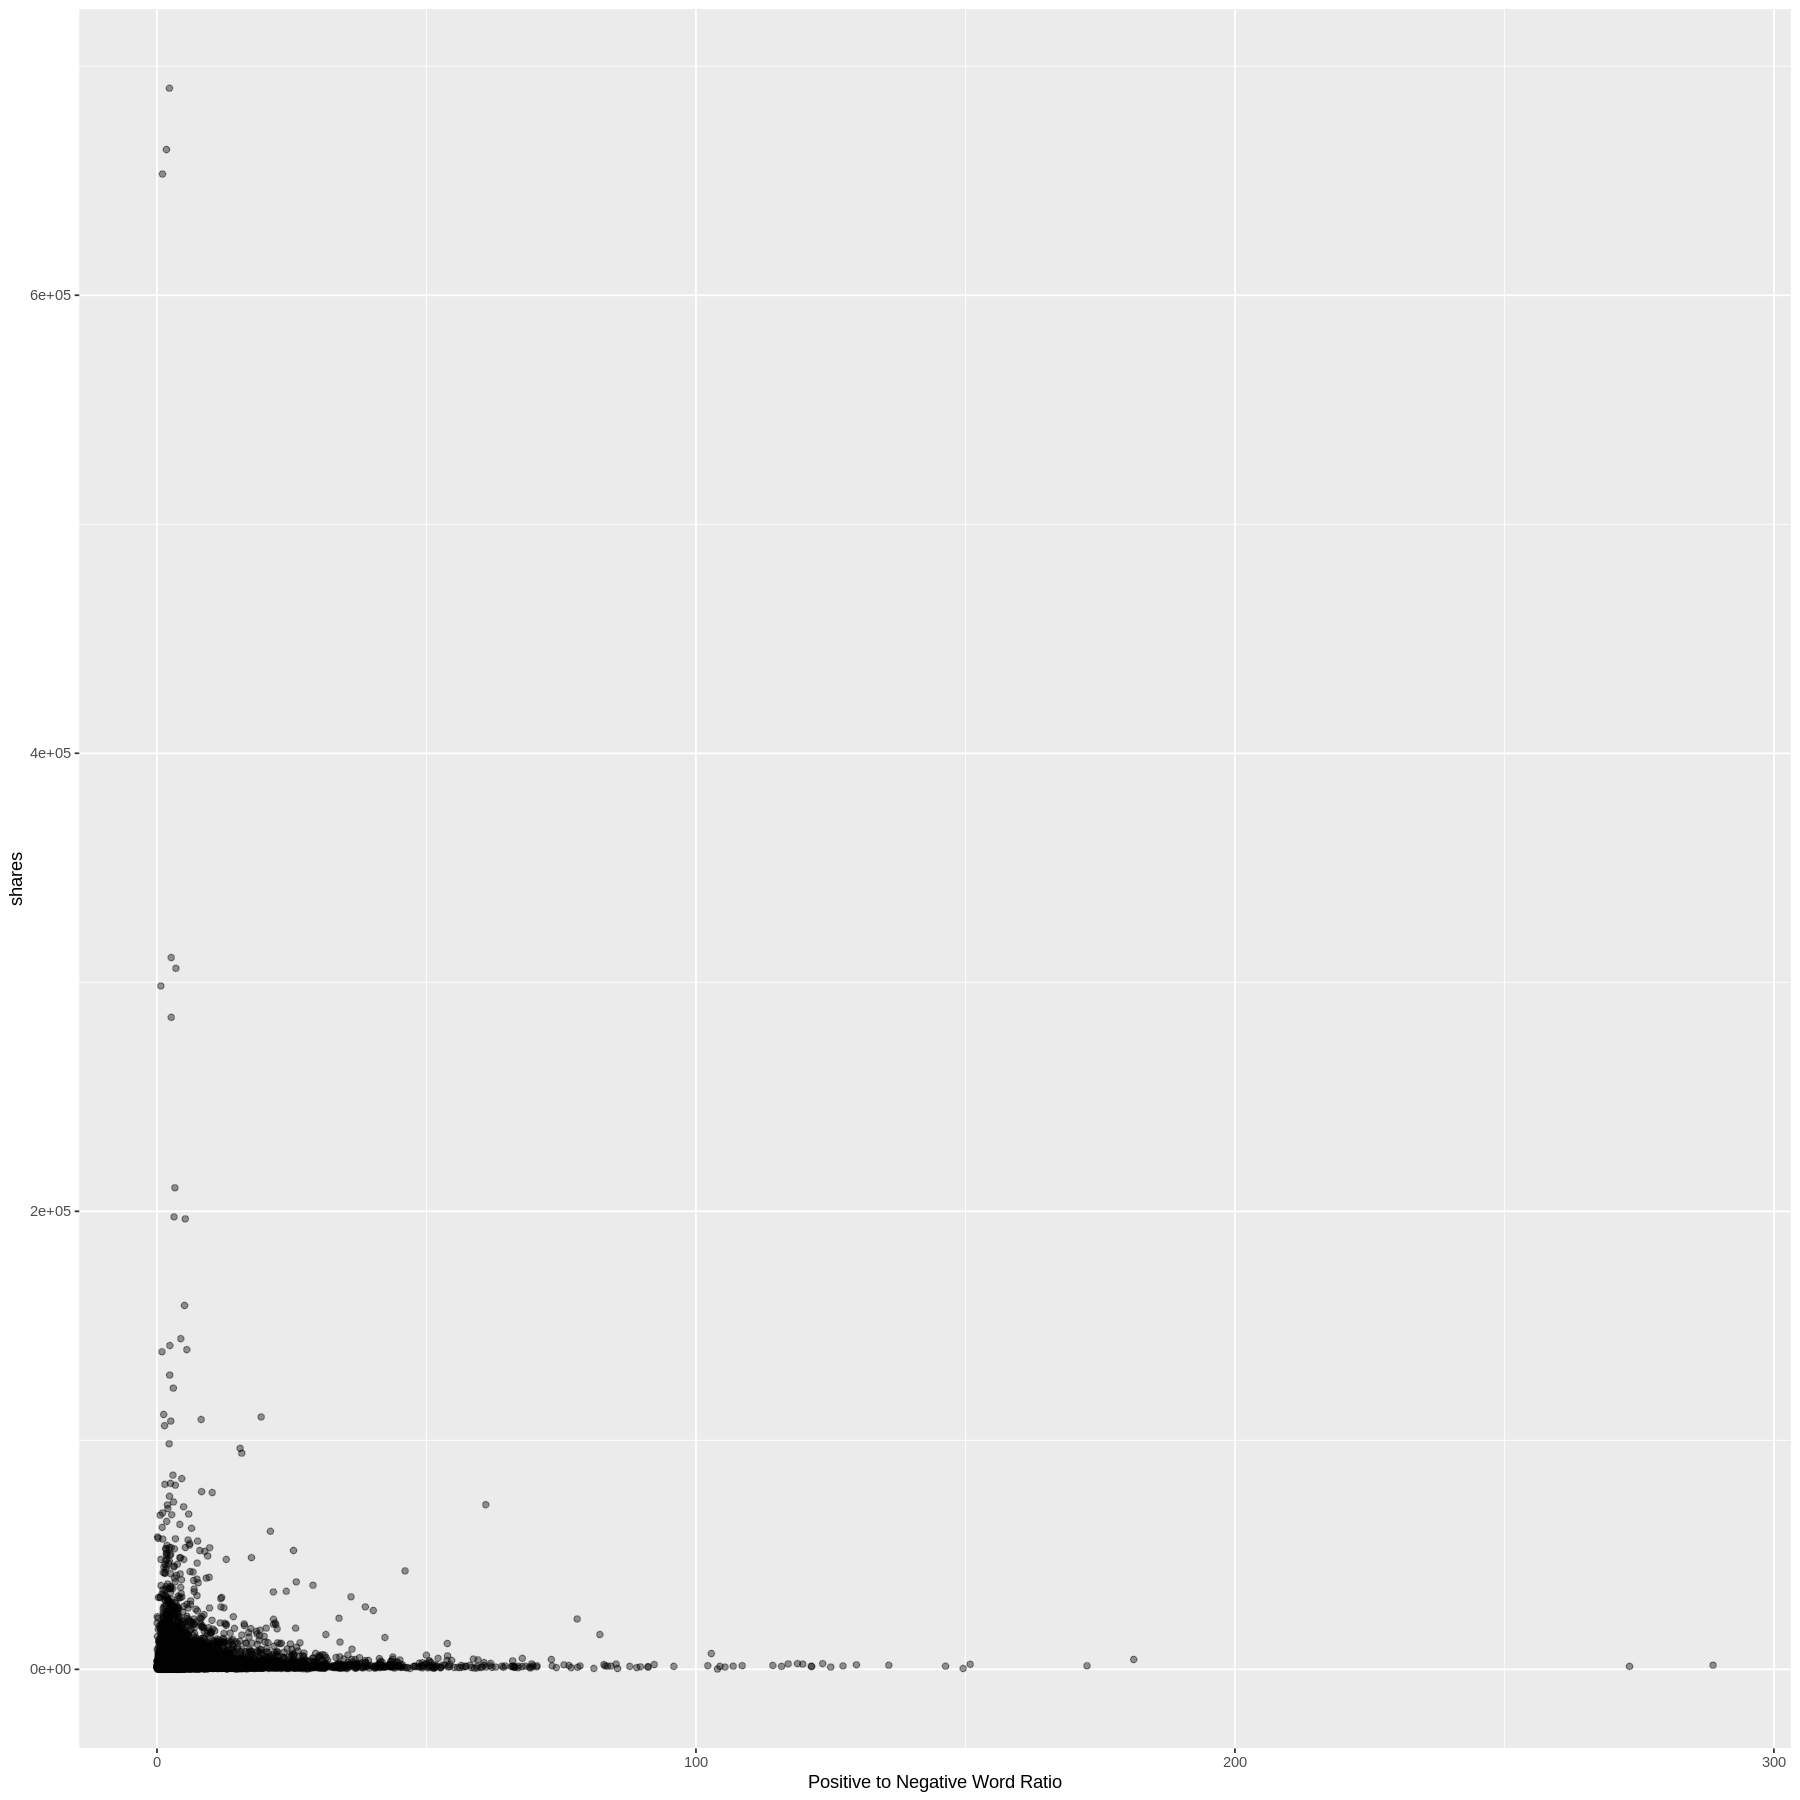

In [24]:
share_spec <- linear_reg() %>% 
       set_engine("lm") %>%
       set_mode("regression")



share_recipe <- recipe(shares ~ ., data = publishing_train) %>%
       step_scale(-shares, -Day_Of_Week, -Genre) %>%
       step_center(-shares, -Day_Of_Week, -Genre)

share_plot <- ggplot(publishing_train, aes(x = abs_pos_neg_ratio, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio")

#head(publishing_train)
share_plot

In [32]:


share_fit <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec) %>%
       fit(publishing_train)

share_fit

share_plot_train <- ggplot(publishing_train, aes(x = abs_pos_neg_ratio, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio", y="Total Shares")+
  facet_grid(Genre ~ Day_Of_Week)+
  geom_smooth(method = "lm", se = FALSE)

share_plot_train

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
         (Intercept)         Genrebusiness       Genretechnology  
             3306.87                339.39                248.98  
      Genrelifestyle            Genreworld     Genresocial_media  
              799.04               -649.98                759.39  
  Day_Of_Weektuesday  Day_Of_Weekwednesday   Day_Of_Weekthursday  
             -580.93               -496.40               -474.34  
   Day_Of_Weekfriday   Day_Of_Weeksaturday     Day_Of_Weeksunday  
             -544.50                -13.24                169.91  
   abs_pos_neg_ratio  
             -113.83  


ERROR: Error in fortify(data): object 'share_preds' not found


In [29]:
share_results <- share_fit %>%
         predict(publishing_test) %>%
         bind_cols(publishing_test) %>%
         metrics(truth = shares, estimate = .pred)

share_results
lm_rmspe <- share_results %>%
          filter(.metric == "rmse") %>%
          select(.estimate) %>%
          pull()


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.059459e+03
rsq,standard,6.096621e-03
mae,standard,2.467772e+03


In [33]:


options(repr.plot.width = 15, repr.plot.height = 15)





share_plot <- ggplot(publishing_test, aes(x = abs_pos_neg_ratio, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Positive to Negative Word Ratio", y="Total Shares")+
  facet_grid(Genre ~ Day_Of_Week)+
  geom_smooth(method = "lm", se = FALSE, data=publishing_train)

`geom_smooth()` using formula 'y ~ x'



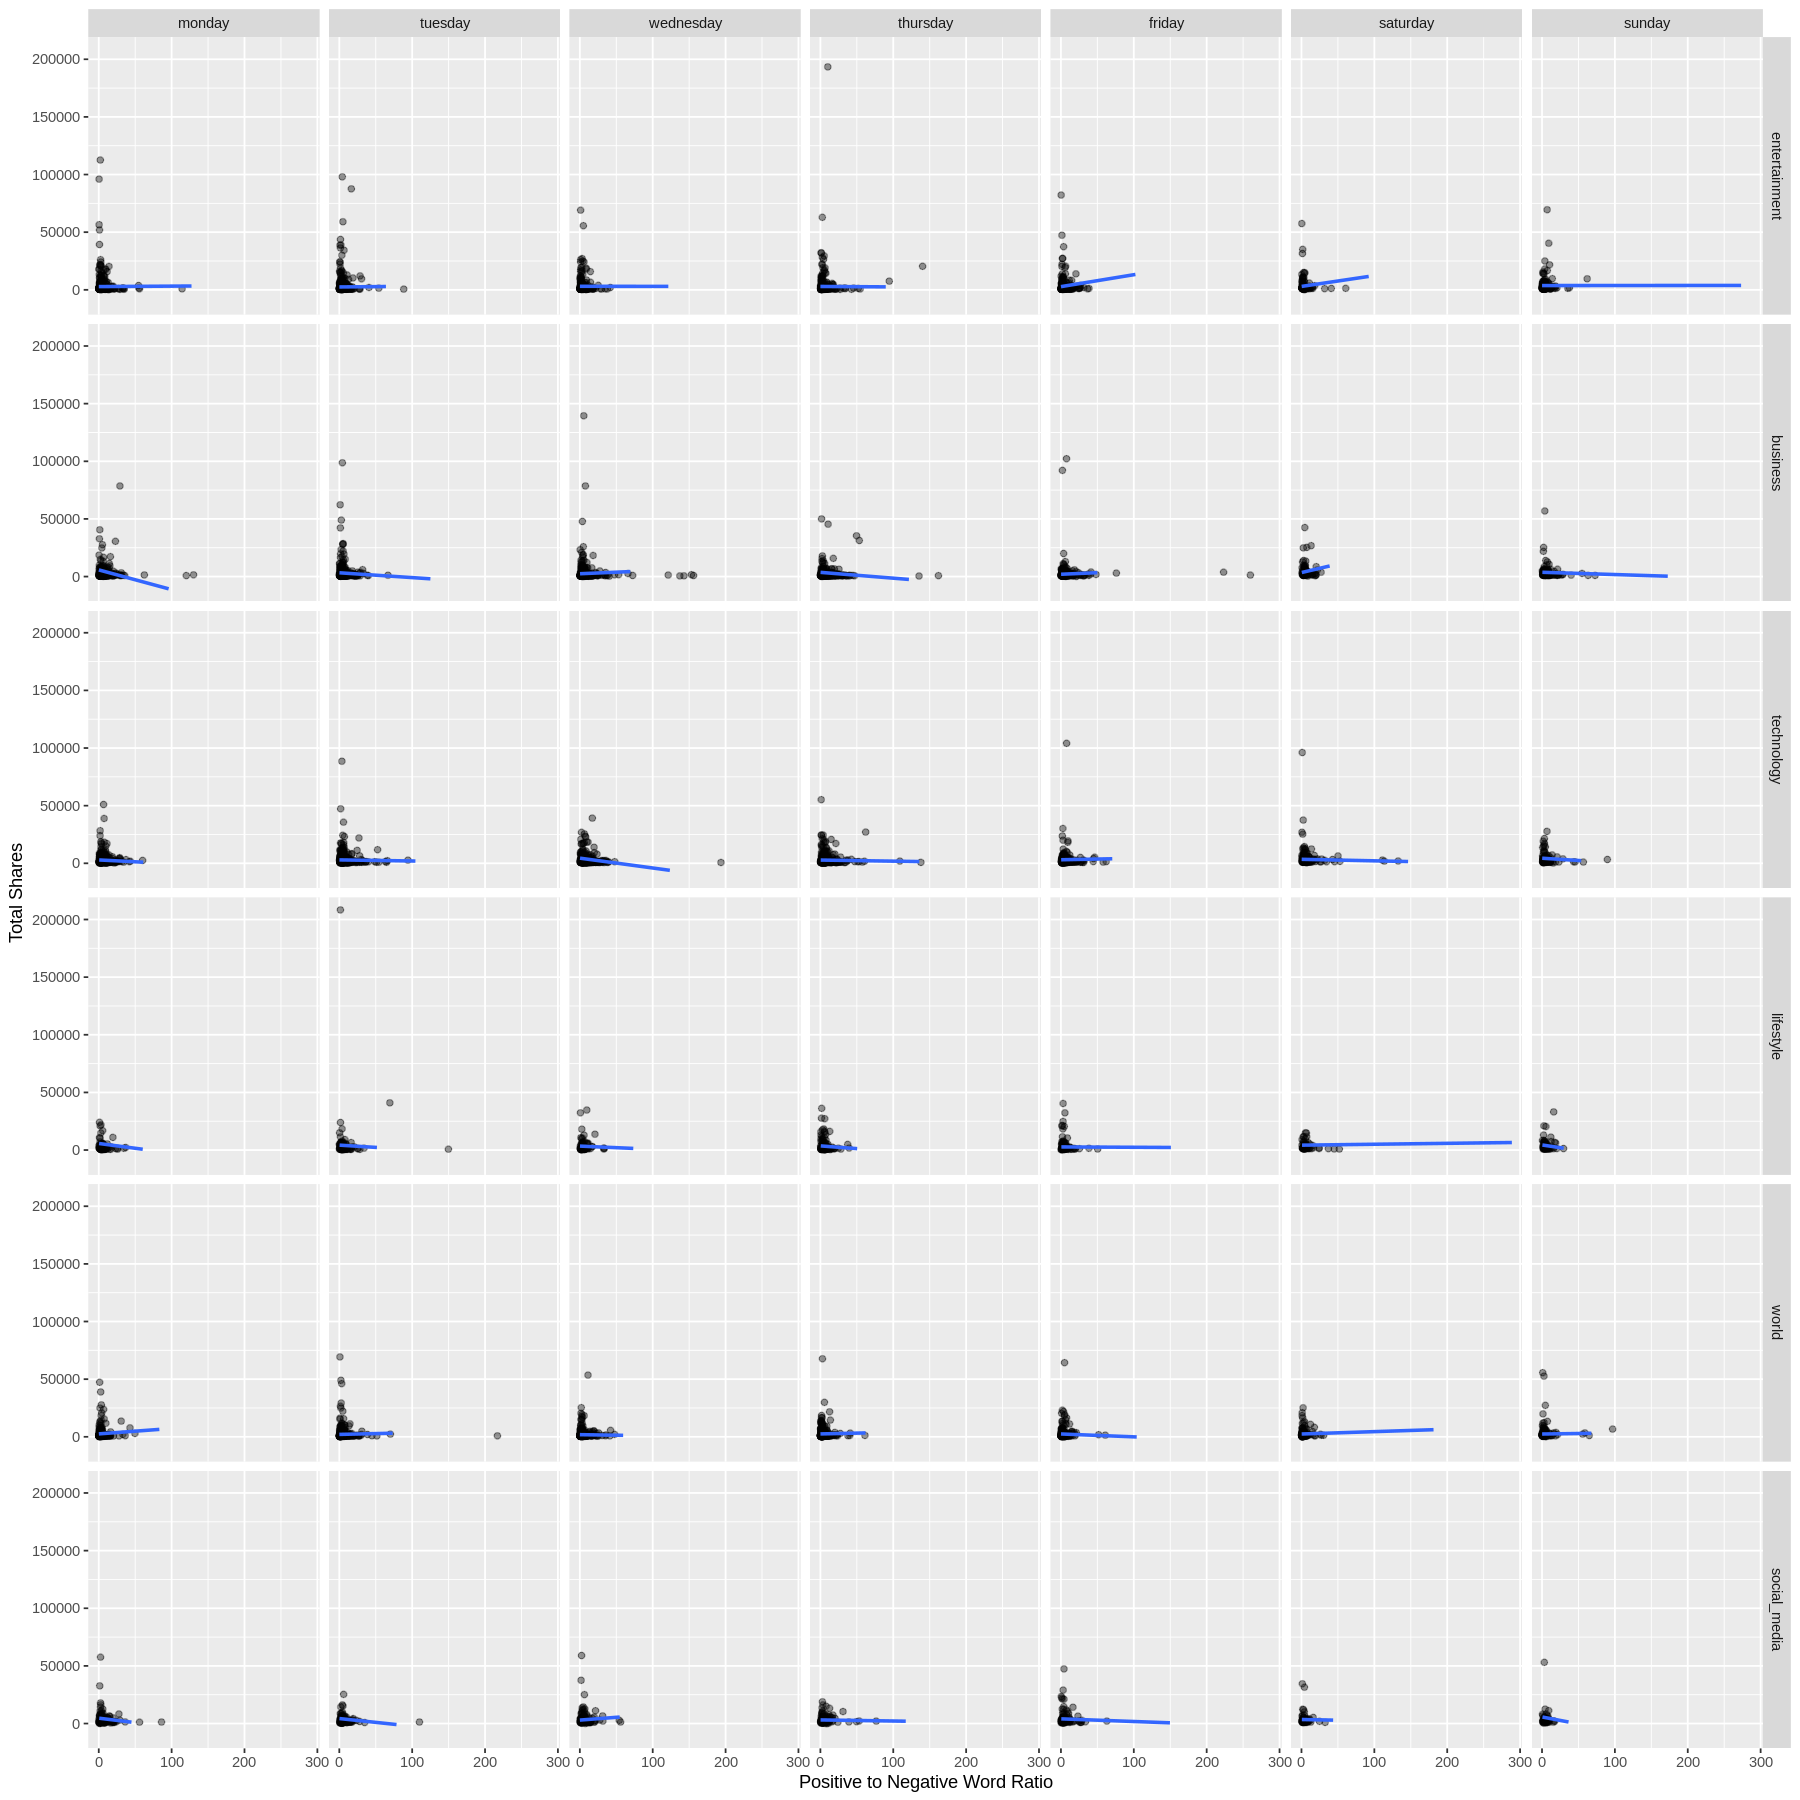

In [34]:
share_plot